# Predict receipt price with generated code

For the second try, I am using Chat GPT-3 to generate code that will create the model. 

In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings

warnings.filterwarnings(action='error')

In [2]:
# Load the data into a Pandas DataFrame
df = pd.read_csv("Receipts August 2022 - V6.csv")
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')
df['time of exit'] = pd.to_datetime(df['time of exit'], format='%H:%M:%S')

# Adding all the columns from third EDA
df['dow'] = df['date'].dt.day_of_week
df['is w'] = df['dow'] > 4
df['is nem'] = df['dow'].apply(lambda dow: 3 < dow < 6)
df['toe hour'] = df['time of exit'].dt.hour
df['toe minute'] = df['time of exit'].dt.minute
df['toe as n'] = df['toe hour'] + df['toe minute'] / 60
df = df.drop(columns=['id'])

# Removing the anomalies
df = df[df['toe as n'] > 15]
df = df[df['receipt price'] < 200]

I chose to predict `receipt price`. To predict this, I chose the highest numbers on the correlation matrix which are `toe as n` (0.31) and `is nem` (0.11). But `dow` will be used because it kind of includes `is nem`.

In [3]:
# Extract the relevant columns from the DataFrame
X = df[['toe as n', 'dow']]
y = df['receipt price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

# Train the linear regression model on the training data
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model's performance on the testing data
print(model.score(X_test, y_test))

-0.21902160150614924


The printed result varies a lot every time the above script is run. This is because of the small dataset. The training data is very scarce, causing the model to be sensitive to a small change in training data. To get around this issue, I will modify this generated script by putting it in a for-loop to get an average model score. Then The best performing model will be selected.

In [4]:
iterations = 1000
model_scores = []
highest_model_score = 0
final_X_test = pd.DataFrame()
final_y_test = pd.DataFrame()
strongest_model = LinearRegression()
highest_model_score = 0

for i in range(1, iterations + 1):
  # Split the data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

  # Train the linear regression model on the training data
  model = LinearRegression()
  model.fit(X_train, y_train)

  # Evaluate the model's performance on the testing data
  model_score = model.score(X_test, y_test)
  model_scores.append([i, model_score])

  # Update the strongest model
  if(model_score > highest_model_score):
    strongest_model = model
    final_X_test = X_test
    final_y_test = y_test
    highest_model_score = model_score

average_model_score = np.average(model_scores, axis=0)[1]
print(f"Average model score from {iterations} iterations: {average_model_score}")
print(f"Strongest model score from {iterations} iteratinos: {highest_model_score}")

Average model score from 1000 iterations: -0.01976507683301416
Strongest model score from 1000 iteratinos: 0.3552261839681634


The average model score is negative meaning that the average model is useless. The best performing model will be used to force a result from this experience. Below are some charts that show the variation from the 1000 iterations.

In [5]:
# Creating a numpy array
npArr = np.array(model_scores)
x = npArr[:, 1]

# Creating a datafram
dfX = pd.DataFrame()
dfX['x'] = x

dfX.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
x,1000.0,-0.019765,0.232922,-2.508849,-0.100695,0.024063,0.120604,0.355226


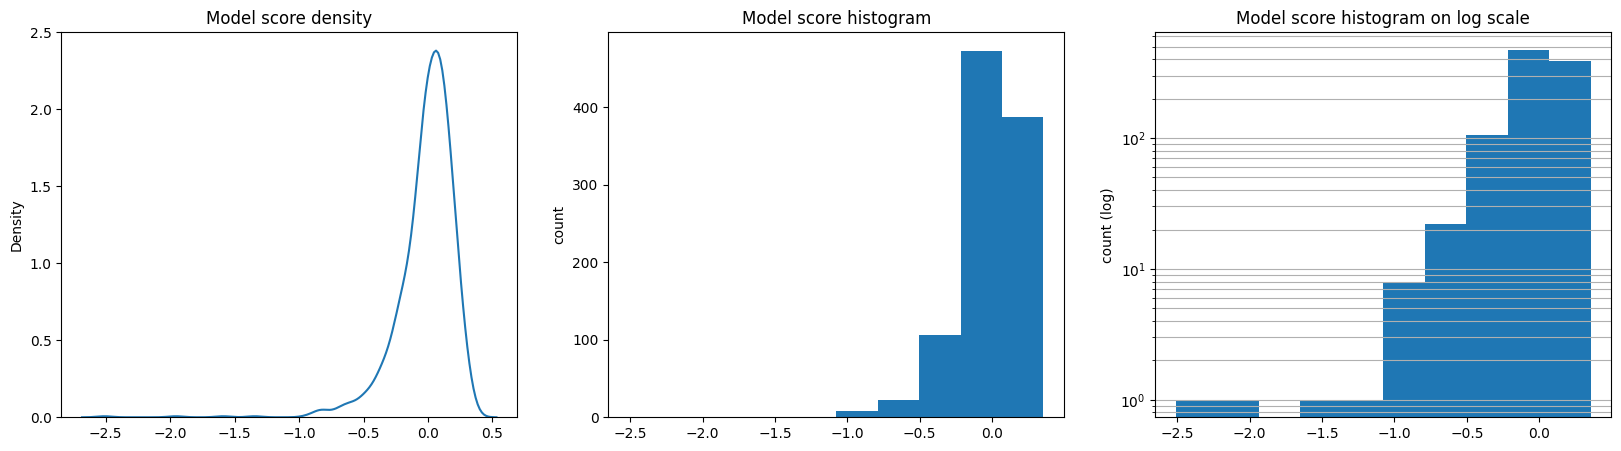

In [6]:
fig, ax =   plt.subplots(1, 3, figsize=(20, 5))

ax[0].set_title("Model score density")
sns.kdeplot(x, ax=ax[0])

ax[1].set_title("Model score histogram")
ax[1].set_ylabel("count")
ax[1].hist(x)

ax[2].set_title("Model score histogram on log scale")
ax[2].set_ylabel("count (log)")
ax[2].hist(x, log=True)
ax[2].grid(visible=True, axis="y", which="both")



Now, let's use the strongest model and apply the test data.

In [7]:
def get_df(toe_as_n, dow):
    _df = pd.DataFrame()
    _df['toe as n'] = [toe_as_n]
    _df['dow'] = [dow]
    return _df

In [8]:
# Use the strongest model to make predictions on new data
new_toe_as_n = 20.5
new_dow = 1 # (Tuesday)

result = strongest_model.predict(get_df(new_toe_as_n, new_dow))[0]
print(f"Predicted receipt price: €{result:.2f}")

Predicted receipt price: €68.57


The model works: it gave a predicted receipt price. Lets use the test data to see the deviation from the actual value and plot the result to see the accuracy

In [40]:
# Creating the test results
test_results = []

for index, row in final_X_test.iterrows():
  test_toe_as_n, test_dow = row
  predicted_receipt_price = strongest_model.predict(get_df(test_toe_as_n, test_dow))[0]
  test_results.append([test_toe_as_n, predicted_receipt_price])

test_results = np.array(test_results)

In [43]:
# Creating dataframes for easier plotting

test_results_df = pd.DataFrame()
test_results_df["toe as n"] = test_results[:,0]
test_results_df["receipt price"] = test_results[:,1]

test_input_df = pd.DataFrame()
test_input_df["toe as n"] = final_X_test["toe as n"]
test_input_df["receipt price"] = final_y_test

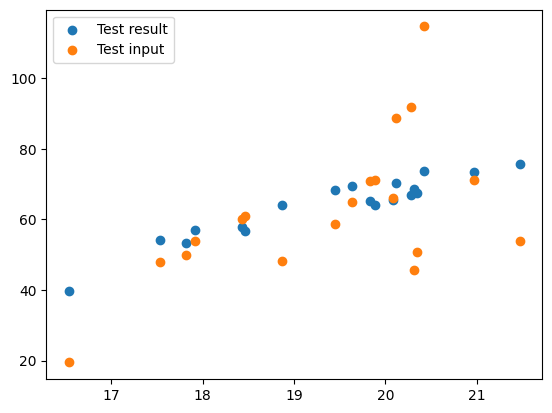

In [47]:
# Plotting the test result data
plt.scatter(test_results_df["toe as n"], test_results_df["receipt price"]).set_label("Test result")

# Plotting the actual values corresponding to the test data
plt.scatter(test_input_df["toe as n"], test_input_df["receipt price"]).set_label("Test input")

plt.legend()

Let's look at the prediction lines

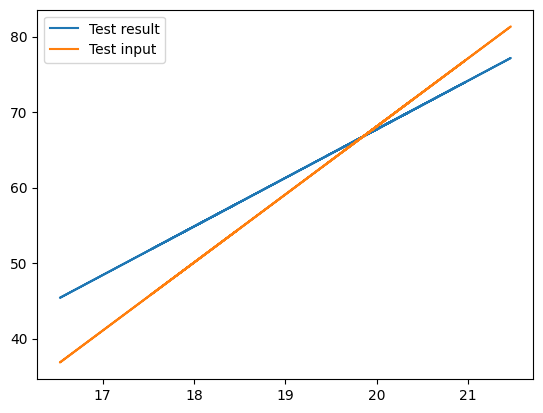

In [48]:
def plot_prediction_line(x, y, label):
    #obtain m (slope) and b(intercept) of linear regression line
    m, b = np.polyfit(x, y, 1)

    #add linear regression line to scatterplot 
    plt.plot(x, m*x+b, label=label)

plot_prediction_line(test_results_df["toe as n"], test_results_df["receipt price"], "Test result")
plot_prediction_line(test_input_df["toe as n"], test_input_df["receipt price"], "Test input")

plt.legend()

The above plots indicate that the model is working. But let's see the deviation in chart form. To do this, the difference between each point on the same axis needs to be calculated.

In [70]:
receipt_price_differences = []
receipt_price_differences_as_percentage = []

test_input_as_array = np.asarray(test_input_df)

for index, row in test_results_df.iterrows():
  inp_rp = test_input_as_array[index][1]
  res_rp = row[1]

  receipt_price_difference = abs(res_rp - inp_rp)
  receipt_price_differences.append(receipt_price_difference)

  diff_in_percentage = (abs(res_rp - inp_rp) / (abs(res_rp + inp_rp) / 2)) * 100
  receipt_price_differences_as_percentage.append(diff_in_percentage)

print(f"Here are some example differences:      {receipt_price_differences[:5]}")
print(f"Here are some example differences as %: {receipt_price_differences_as_percentage[:5]}")

Here are some example differences:      [9.665043224528226, 2.1566535526769, 25.011524564498075, 22.905639477864767, 16.775758930354456]
Here are some example differences as %: [15.236731851220583, 2.9796952329961055, 31.463317697696514, 40.00788010496669, 28.391201515771197]


(array([7., 3., 1., 1., 4., 1., 1., 0., 0., 1.]),
 array([ 0.79554412,  7.53597793, 14.27641175, 21.01684557, 27.75727939,
        34.49771321, 41.23814703, 47.97858085, 54.71901466, 61.45944848,
        68.1998823 ]),
 <BarContainer object of 10 artists>)

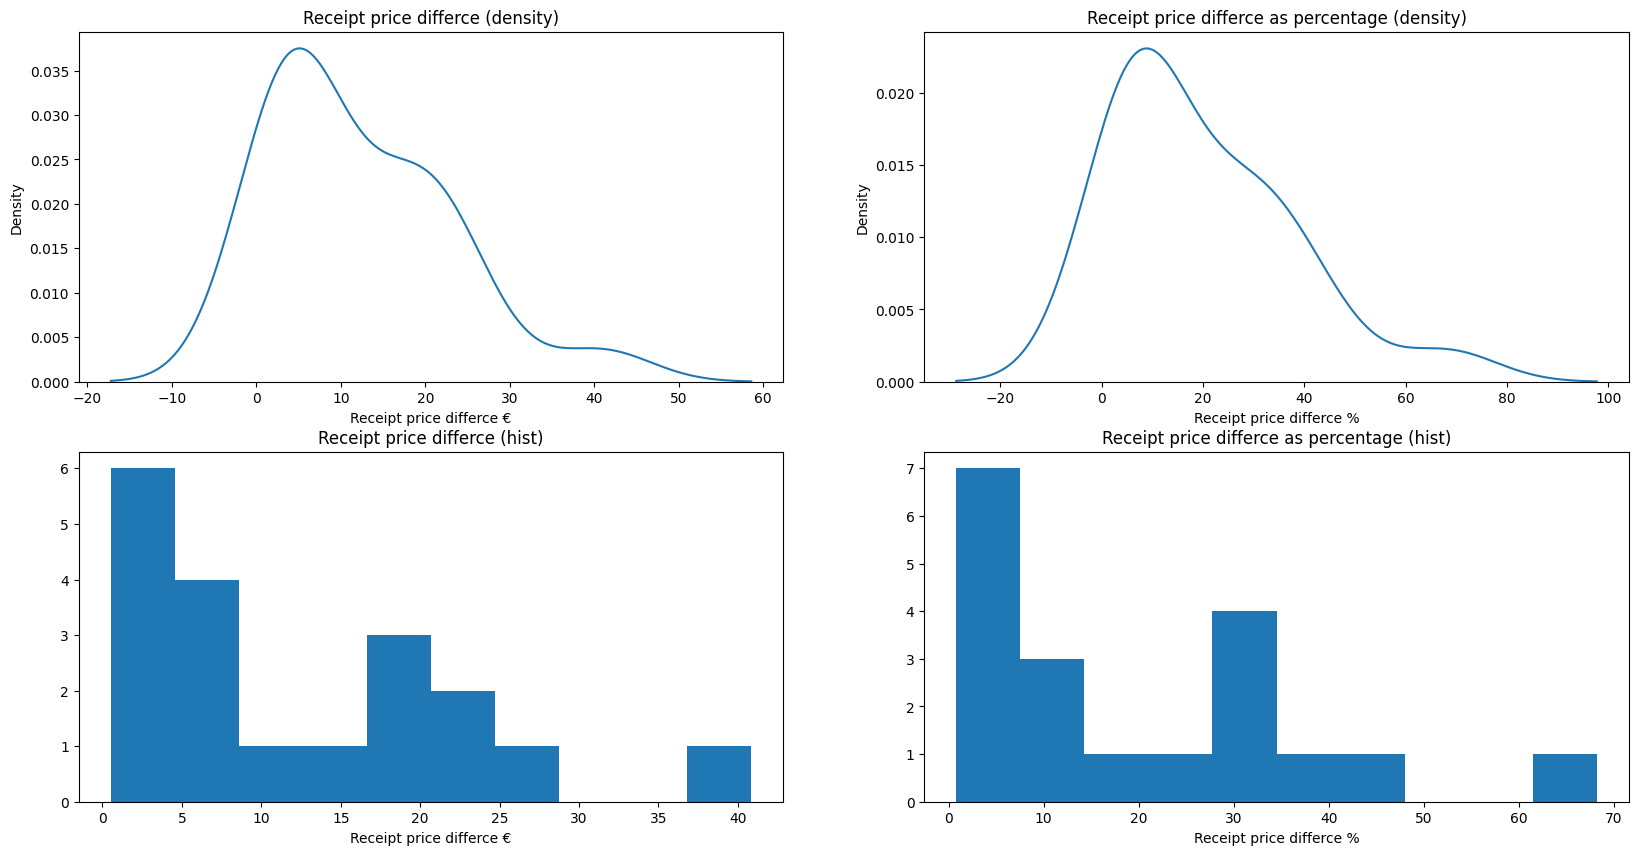

In [89]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

ax[0, 0].set_title("Receipt price differce (density)")
ax[0, 0].set_xlabel("Receipt price differce €")
sns.kdeplot(receipt_price_differences, ax=ax[0, 0])

ax[0, 1].set_title("Receipt price differce as percentage (density)")
ax[0, 1].set_xlabel("Receipt price differce %")
sns.kdeplot(receipt_price_differences_as_percentage, ax=ax[0, 1])

ax[1, 0].set_title("Receipt price differce (hist)")
ax[1, 0].set_xlabel("Receipt price differce €")
ax[1, 0].hist(receipt_price_differences)

ax[1, 1].set_title("Receipt price differce as percentage (hist)")
ax[1, 1].set_xlabel("Receipt price differce %")
ax[1, 1].hist(receipt_price_differences_as_percentage)

In [90]:
# Add chart that shows upper and lower band for each toe as n using the difference

# Conclusion

The red dots follow the trend of the `receipt price` increasing as `toe as n` increases. This means that I have succesfully created a regression model using partly generated code by Chat GPT-3.